# Recommender Evaluation
### By Nicholas Roze-Freitas and Coby Wilcox

## Abstract
Recommender systems are an often behind the scenes but rather foundational aspect of life today. Usually when we engage with media, we are engaging with a recommender: using social media, reading the news, buying something online and much more. Regardless of how ubiquitous recommenders are, evaluating and making them presents interesting and unique problems. Recommenders get gauged on several different metrics of accuracy ____ (put metrics here) ___. Through this project we aim to evaluate the performance of several recommender systems, frameworks and how we might improve them in the context of the Microsoft News Dataset. This report will be split into a couple main chapters, the first one below being exploratory data analysis. After walking through our analysis and preparation of the microsoft news dataset, we delve into recommender system frameworks, metrics and evalulation.

## Exploratory data analysis

Before evaluating any recommender frameworks, models or hyperparameters, we will be engaging in exploratory data analysis on the Microsoft News Dataset. The Microsoft news dataset contains 4 separate tab-separated files: behaviors entity_embeddings, news and relation_embeddings. The main focus for now will be on behaviors and news, which gives us data on the catalog and users with interactions respectively. 

In [1]:
## IMPORTS ##
import eda_modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


### Changing file formats
We first noticed that our files were in unlabeled .tsv files, to make our data analysis easier in the future these .tsv files were turned into csvs with columns as specified by the datasets github repo. Once these columns were created, exploratory data analysis could be performed more easily.

### Initial understanding
Within the MIND dataset (might want to make it clear that the mind dataset is referring to the microsoft news dataset at some point so that it is more clear to the reader) there are two main files, the behaviors and news. News contains information on the articles that users interact with like its ID, category, sub-category, title, abstract, url and some entities for use within embeddings (to my understanding). Behaviors focuses on impression ids, user ids, time, user history and impressions. Since there are two main datasets, we will be starting with some examination of each, and then examination of how they might interact.

In [ ]:
news = pd.read_csv('../MIND_small/csv/news.csv')
# news.head()


### Starting with news
Within the news dataset, several different categories and subcategories exist. We first want to understand how large each category may be, and the amount of subcategories that exist within it. By creating a treeplot we can extrapolate a few things about our dataset before diving deeper into investigation. Immediately noticeable is that the largest categories are news and sports, whereas entertainment and movies are much smaller. This could lead to potential bias within recommendations worsening success metrics such as coverage or serendipity which rely on the recommender to make wide selections of recommendations. While this does cause consideration of an IDF technique to add weights to our categories, we still have more exploration to do.

In [65]:
fig = eda_modules.plot_sub_categories(news)
fig.show()

Now that we have had an initial peak at our news datas categories and sub-categories, we can check the distribution of categories in comparison with each other. As we can see in the figure below, news and sports still are much larger than any other category, with kids middleeast and northamerica having so few counts they are barely visible. To ameliorate this, we will test to see how many users have interacted with the categories that have the smallest counts. Afterwards we may consider applying some form of outlier removal as well as normalization through an inverse category frequency.

[]

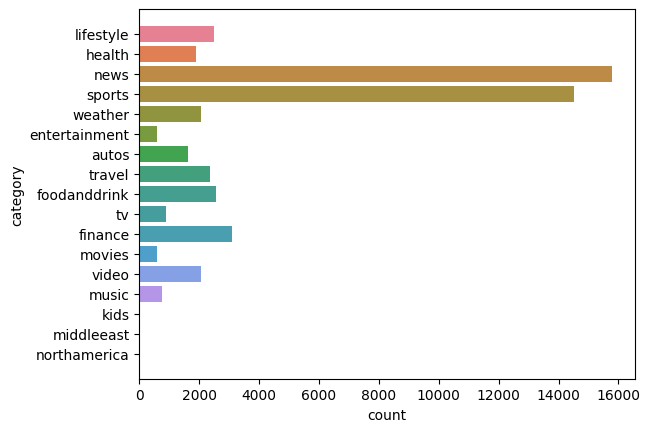

In [4]:
fig = eda_modules.plot_categories(news)
fig.plot()

### Missing Values in News
Examining the news dataset provided information about the count of missing values, all of which lie within the abstract, title entities and the abstract entities. Currently the abstract will not be utilized for recommendations. However, there is potential to creating an abstract from the web-scraped information from the article. (depending on time we shall see how this goes.)

In [5]:
copynews = news.set_index('news_id')
copynews.loc['N20121']


Unnamed: 0                                                       20003
category                                                         music
sub_category                                                 musicnews
title                   Bob Kingsley, Country Radio Legend, Dead at 80
abstract             Country radio legend Bob Kingley, the longtime...
url                      https://assets.msn.com/labs/mind/AAIW26m.html
title_entities       [{"Label": "Bob Kingsley", "Type": "P", "Wikid...
abstract_entities    [{"Label": "Bob Kingsley", "Type": "P", "Wikid...
Name: N20121, dtype: object

In [68]:
missing_vals = news.isna().sum()
# print(missing_vals.sum())
# news[missing_vals['abstract']] # can utilize this as a mask to get values where missing abstract is true in the main, to see if theres a
# majority of missing abstracts for a specific category
missing_vals
# sns.countplot(news,y='category',hue='category')
# sns.countplot(news[missing_vals['abstract']], color='red',y='category')

Unnamed: 0              0
news_id                 0
category                0
sub_category            0
title                   0
abstract             2666
url                     0
title_entities          3
abstract_entities       4
dtype: int64

### Moving on to Behaviors
The second large chunk of the microsoft news dataset is the behaviors file. Detailing user interactions, history, and times, the behaviors file provides our recommenders information it needs to train and determine what users might like. Additionally since there is an interaction time column, we can utilize temporal data and understand the affect it may have on our results. Starting off our exploration will be an examination into the potential missing values of the behaviors file

In [7]:
behaviors = pd.read_csv('../MIND_small/csv/behaviors.csv')

#### Missing values in behaviors
Within the behaviors file, there are certain users that do not have any history which can be a problem if these users have no history on their most recent interaction. If a user has no history whatsoever before the training cutoff point for time, then they must be removed as the recommender system will not generate anything for them that is personalized unless it is taking article popularity into account (hhmmmmm that might actually be a good idea is to take article popularity into account)

In [9]:
# print(len(pd.unique(behaviors['user_id'])))
# print(len(behaviors['user_id']))
# print(behaviors.columns)
# print(pd.unique(copynews['sub_category']))

# do missing value analysis on the behaviors csv
missing_behaviors = behaviors.isna().sum()
missing_behaviors

Unnamed: 0          0
impression_id       0
user_id             0
time                0
history          3238
impressions         0
dtype: int64

In [26]:

from tkinter.tix import PopupMenu


behaviors['time'] = pd.to_datetime(behaviors['time'])

## Gets the most recent time for interactions 
max_idcs = behaviors.groupby('user_id')['time'].idxmax()
max_behaviors = behaviors.loc[max_idcs]
# def swap_to_genres(history):
#     """ 
#     Swaps the articles in a users history to the corresponding genre
#     # """
#     # for interaction in history:
#     # copynews.loc['N55528']['category']

# ## could define a separate function that just creates a new dataframe, updating the column for each genre by 1 for every time an article appears in the maximum history of a user
    
def create_popularity_df():
    """ 
    Creates a dataframe with the popularity of every sub-category and category. The category popularity gets calculated as a biproduct of the sub-category popularity.
    """
    popoularity_dict = {category: 0 for category in pd.unique(copynews['category'])}
    for history in max_behaviors['history']:
        if type(history) != float:
            for news_id in history.split():
                sub_category = copynews.loc[news_id]['category']
                popoularity_dict[sub_category] += 1

    return pd.DataFrame(data=popoularity_dict, index=[1])

category_popularity = create_popularity_df()
category_popularity.head()

['N20121 N33998 N45954 N55743 N50095 N18870 N53465 N42330 N51705 N20575', 'N29641 N1789 N41244', 'N47937 N51706 N56447 N61319 N27644 N18030 N27256 N33976 N34562 N2735 N20639 N22816 N56814 N46444 N59380', 'N39074 N26619 N31431 N1282 N61052 N41668 N50839 N28257', 'N23912 N30148 N46754 N33117 N9619 N36526 N44495 N35304 N45336 N40977 N33876 N60000 N29207 N59704 N32312 N63049 N38870 N52496 N63422 N38390 N10376 N23614 N5812', 'N56253 N37059 N53827 N16290 N31304', 'N52109 N19979 N18551 N9824 N28852 N13374 N50710 N52555 N2003 N40442', 'N38520 N14629 N40772 N63906 N8892 N11894 N59026 N30527 N30765 N58871 N46861 N13404 N5270 N5270 N16655 N65204 N31381 N28257 N53017 N28257', 'N24002 N25292 N1919 N19660', 'N3682 N16605 N61109 N4978 N45778 N41699 N3900']


,lifestyle,health,news,sports,weather,entertainment,autos,travel,foodanddrink,tv,finance,movies,video,music,kids,middleeast,northamerica
1,98916,45253,278614,129298,10895,32444,33465,29762,49021,71786,68694,34881,18441,24560,10,18,0


<Axes: xlabel='value', ylabel='index'>

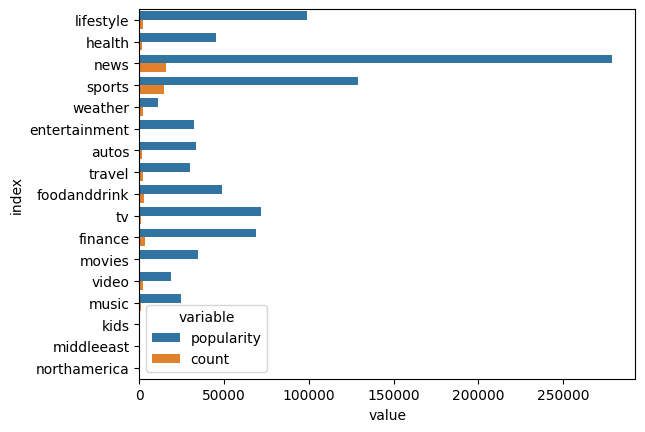

In [63]:
pop_long = category_popularity.melt(value_vars=category_popularity.columns, value_name='popularity')
news_cat = news['category'].value_counts().to_frame()
pop_long.set_index('variable', inplace=True)
concatenated = pd.concat([pop_long, news_cat], axis=1)
concatenated.reset_index(inplace=True)
# concatenated
sns.barplot(data=concatenated.melt(id_vars='index', value_vars=['popularity', 'count']),
            y='index',
            x='value',
            hue='variable')



In [ ]:
my_new_dat = my_dat.melt(id_vars=[], value_vars=my_dat.columns, var_name='sub_category', value_name='count') # type: ignore
sns.barplot(data=my_new_dat, y='sub_category', x='count')


How do we then gauge the most popular genres, or times? 